In [25]:
import pandas as pd
import numpy as np
import seaborn as sns
import requests
import pandas as pd
from pandas_datareader import data
import matplotlib.pyplot as plt

sns.set(style='darkgrid', context='talk', palette='Dark2')

Having imported the appropriate tools, getting market data from a free online source, such as Yahoo Finance, is super easy. Since pandas has a simple remote data access for the Yahoo Finance API data, this is as simple as:

In [50]:
# Define the instruments to download. We would like to see Apple, Microsoft and the S&P500 index.
tickers = ['AAPL', 'MSFT', 'GOOG']

# We would like all available data from 01/01/2000 until 12/31/2016.
start_date = '2000-01-01'
end_date = '2022-10-31'

# User pandas_reader.data.DataReader to load the desired data.
df = data.DataReader(tickers, 'yahoo', start_date, end_date)
df

Attributes   Adj Close                               Close              \
Symbols           AAPL        MSFT        GOOG        AAPL        MSFT   
Date                                                                     
2000-01-03    0.853355   36.555374         NaN    0.999442   58.281250   
2000-01-04    0.781409   35.320522         NaN    0.915179   56.312500   
2000-01-05    0.792844   35.692940         NaN    0.928571   56.906250   
2000-01-06    0.724232   34.497311         NaN    0.848214   55.000000   
2000-01-07    0.758538   34.948112         NaN    0.888393   55.718750   
...                ...         ...         ...         ...         ...   
2022-10-25  152.339996  250.660004  104.930000  152.339996  250.660004   
2022-10-26  149.350006  231.320007   94.820000  149.350006  231.320007   
2022-10-27  144.800003  226.750000   92.599998  144.800003  226.750000   
2022-10-28  155.740005  235.869995   96.580002  155.740005  235.869995   
2022-10-31  153.460693  233.059998   95.110001  153.460693  233.059998   

Attributes                    High                                 Low  \
Symbols           GOOG        AAPL        MSFT        GOOG        AAPL   
Date                                                                     
2000-01-03         NaN    1.004464   59.312500         NaN    0.907924   
2000-01-04         NaN    0.987723   58.562500         NaN    0.903460   
2000-01-05         NaN    0.987165   58.187500         NaN    0.919643   
2000-01-06         NaN    0.955357   56.937500         NaN    0.848214   
2000-01-07         NaN    0.901786   56.125000         NaN    0.852679   
...                ...         ...         ...         ...         ...   
2022-10-25  104.930000  152.490005  251.039993  105.099998  149.360001   
2022-10-26   94.820000  151.990005  238.300003   98.540001  148.039993   
2022-10-27   92.599998  149.050003  233.690002   95.169998  144.130005   
2022-10-28   96.580002  157.500000  236.600006   96.860001  147.820007   
2022-10-31   95.110001  154.149902  234.919998   96.349998  151.929993   

Attributes                                Open                          \
Symbols           MSFT        GOOG        AAPL        MSFT        GOOG   
Date                                                                     
2000-01-03   56.000000         NaN    0.936384   58.687500         NaN   
2000-01-04   56.125000         NaN    0.966518   56.781250         NaN   
2000-01-05   54.687500         NaN    0.926339   55.562500         NaN   
2000-01-06   54.187500         NaN    0.947545   56.093750         NaN   
2000-01-07   53.656250         NaN    0.861607   54.312500         NaN   
...                ...         ...         ...         ...         ...   
2022-10-25  245.830002  103.019997  150.089996  247.259995  103.300003   
2022-10-26  230.059998   94.570000  150.960007  231.169998   96.760002   
2022-10-27  225.779999   91.900002  148.070007  231.039993   94.309998   
2022-10-28  226.050003   92.322998  148.199997  226.240005   92.529999   
2022-10-31  231.149994   94.389999  153.154999  233.759995   95.779999   

Attributes       Volume                          
Symbols            AAPL        MSFT        GOOG  
Date                                             
2000-01-03  535796800.0  53228400.0         NaN  
2000-01-04  512377600.0  54119000.0         NaN  
2000-01-05  778321600.0  64059600.0         NaN  
2000-01-06  767972800.0  54976600.0         NaN  
2000-01-07  460734400.0  62013600.0         NaN  
...                 ...         ...         ...  
2022-10-25   74732300.0  34775500.0  29910200.0  
2022-10-26   88194300.0  82543200.0  71504300.0  
2022-10-27  109180200.0  40424600.0  54036500.0  
2022-10-28  164659100.0  40614800.0  35666500.0  
2022-10-31   51189930.0  11836907.0  12251137.0  

[5745 rows x 18 columns]

In [27]:
tesla = data.DataReader('TSLA', 'yahoo', start_date, end_date)
tesla

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2010-06-29,1.666667,1.169333,1.266667,1.592667,281494500.0,1.592667
2010-06-30,2.028000,1.553333,1.719333,1.588667,257806500.0,1.588667
2010-07-01,1.728000,1.351333,1.666667,1.464000,123282000.0,1.464000
2010-07-02,1.540000,1.247333,1.533333,1.280000,77097000.0,1.280000
2010-07-06,1.333333,1.055333,1.333333,1.074000,103003500.0,1.074000
...,...,...,...,...,...,...
2022-10-25,224.350006,210.000000,210.100006,222.419998,96507900.0,222.419998
2022-10-26,230.600006,218.199997,219.399994,224.639999,85012500.0,224.639999
2022-10-27,233.809998,222.850006,229.770004,225.089996,61638800.0,225.089996


#### Preparing the Data

Let us assume we are interested in working with the Close prices which have been already been adjusted by Yahoo finance to account for stock splits. We want to make sure that all weekdays are included in our dataset, which is very often desirable for quantitative trading strategies.

Of course, some of the weekdays might be public holidays in which case no price will be available. For this reason, we will fill the missing prices with the latest available prices:

In [28]:
# Getting just the adjusted closing prices. This will return a Pandas DataFrame
# The index in this DataFrame is the major index of the data frame.
close = df['Close']
volume = df['Volume']
open = df['Open']

# Getting all weekdays between 01/01/2000 and 12/31/2016  https://pandas.pydata.org/docs/user_guide/timeseries.html#timeseries-offset-aliases
all_weekdays = pd.date_range(start=start_date, end=end_date, freq='B')  # B stands for business day frequency

# How do we align the existing prices in adj_close with our new set of dates?
# All we need to do is reindex close using all_weekdays as the new index     https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.reindex.html
close = close.reindex(all_weekdays)
volume = volume.reindex(all_weekdays)

# Reindexing will insert missing values (NaN) for the dates that were not present
# in the original set. To cope with this, we can fill the missing by replacing them
# with the latest available price for each instrument.  https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.fillna.html
close = close.fillna(method='ffill')
volume = volume.fillna(method='ffill')


In [29]:
close.to_csv(index = False)    # https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.to_csv.html
pass

In [30]:
# print(all_weekdays)

In [31]:
close.describe()

Symbols,AAPL,MSFT,GOOG
count,5956.000000,5956.000000,4748.000000
mean,29.094948,67.529209,37.090651
std,42.206820,74.134625,34.940947
min,0.234286,15.150000,2.490913
25%,1.813661,26.933750,12.567768
50%,12.520000,31.336875,22.516726
75%,33.775626,64.269997,53.008500
max,182.009995,343.109985,150.709000


In [32]:
volume.describe()

Symbols,AAPL,MSFT,GOOG
count,5.956000e+03,5.956000e+03,4.748000e+03
mean,4.140408e+08,5.209703e+07,1.234385e+08
std,3.852994e+08,3.079145e+07,1.525895e+08
min,3.934000e+07,7.425600e+06,1.584340e+05
25%,1.433122e+08,2.968082e+07,3.001800e+07
50%,2.980684e+08,4.715705e+07,6.896277e+07
75%,5.504835e+08,6.581272e+07,1.542892e+08
max,7.421641e+09,5.910522e+08,1.650833e+09


In [33]:
open.describe()

Symbols,AAPL,MSFT,GOOG
count,5745.000000,5745.000000,4583.000000
mean,29.121353,67.591274,37.107523
std,42.210279,74.210253,34.972100
min,0.231964,15.200000,2.470490
25%,1.823571,26.920000,12.525676
50%,12.522857,31.280001,22.501907
75%,33.880001,64.260002,52.995501
max,182.630005,344.619995,151.863495


In [51]:
def close_print(tickers):
    for i in tickers:
        # Get the ticker timeseries. This now returns a Pandas Series object indexed by date.
        ticker = close.loc[:, i]

        # Calculate the 20 and 100 days moving averages of the closing prices
        short_rolling_ticker = ticker.rolling(window=20).mean()
        long_rolling_ticker = ticker.rolling(window=100).mean()

        # Plot everything by leveraging the very powerful matplotlib package
        fig, ax = plt.subplots(figsize=(18,11))

        plt.title(i)

        ax.plot(ticker.index, ticker, label=i)
        ax.plot(short_rolling_ticker.index, short_rolling_ticker, label='20 days rolling')
        ax.plot(long_rolling_ticker.index, long_rolling_ticker, label='100 days rolling')

        ax.set_xlabel('Date')
        ax.set_ylabel('Adjusted closing price ($)')
        ax.legend()


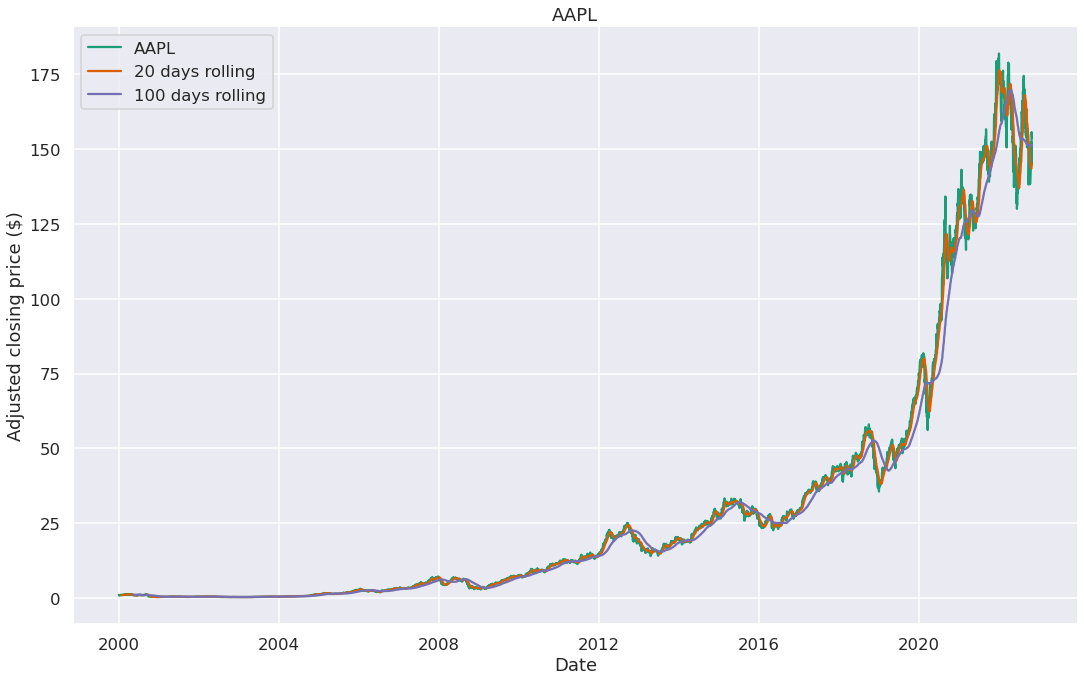

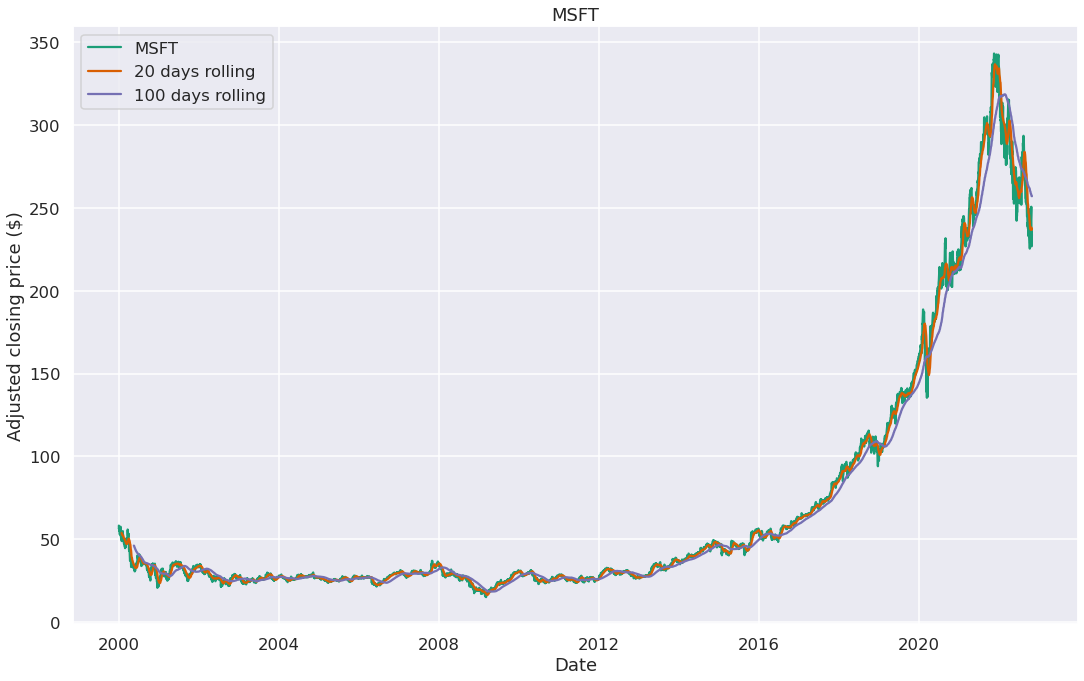

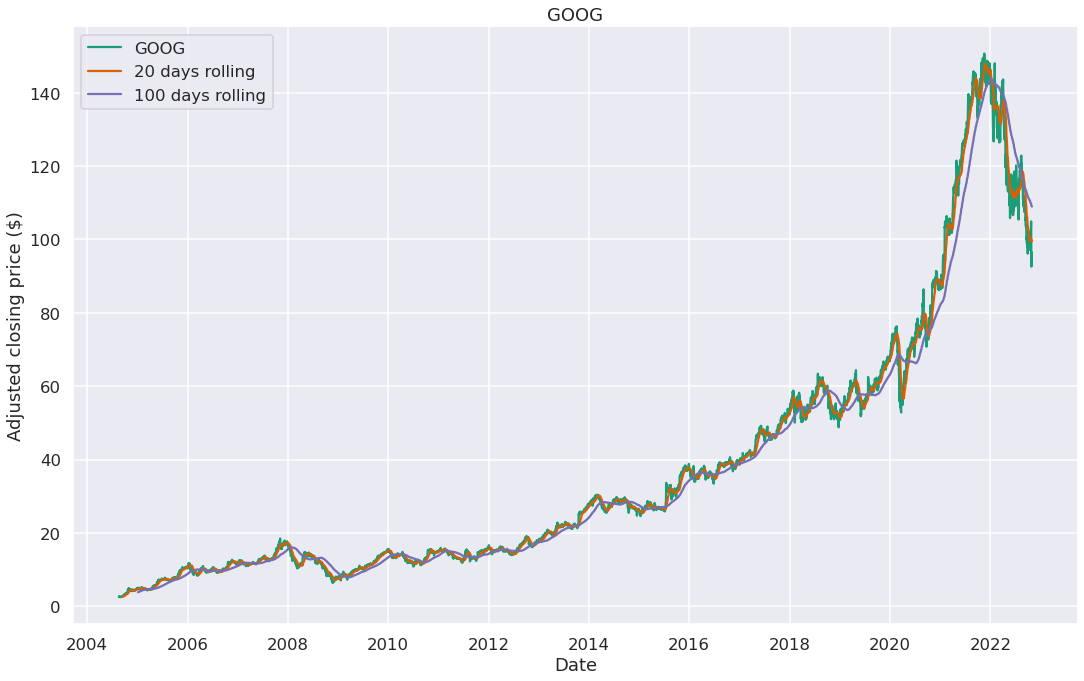

In [52]:
close_print(tickers)

In [53]:
def volume_print(tickers):
    for i in tickers:
        # Get the ticker timeseries. This now returns a Pandas Series object indexed by date.
        ticker = volume.loc[:, i]

        # Calculate the 30 and 100 days moving averages of the closing prices
        short_rolling_ticker = ticker.rolling(window=30).mean()
        long_rolling_ticker = ticker.rolling(window=100).mean()

        # short_rolling_ticker = ticker.rolling(window=30, center=True).mean()
        # long_rolling_ticker = ticker.rolling(window=100, center=True).mean()

        # Plot everything by leveraging the very powerful matplotlib package
        fig, ax = plt.subplots(figsize=(18,11))

        plt.title(i)

        ax.plot(ticker.index, ticker, label=i)
        ax.plot(short_rolling_ticker.index, short_rolling_ticker, label='30 days rolling')
        ax.plot(long_rolling_ticker.index, long_rolling_ticker, label='100 days rolling')

        ax.set_xlabel('Date')
        ax.set_ylabel('Stock Volume')
        ax.legend()


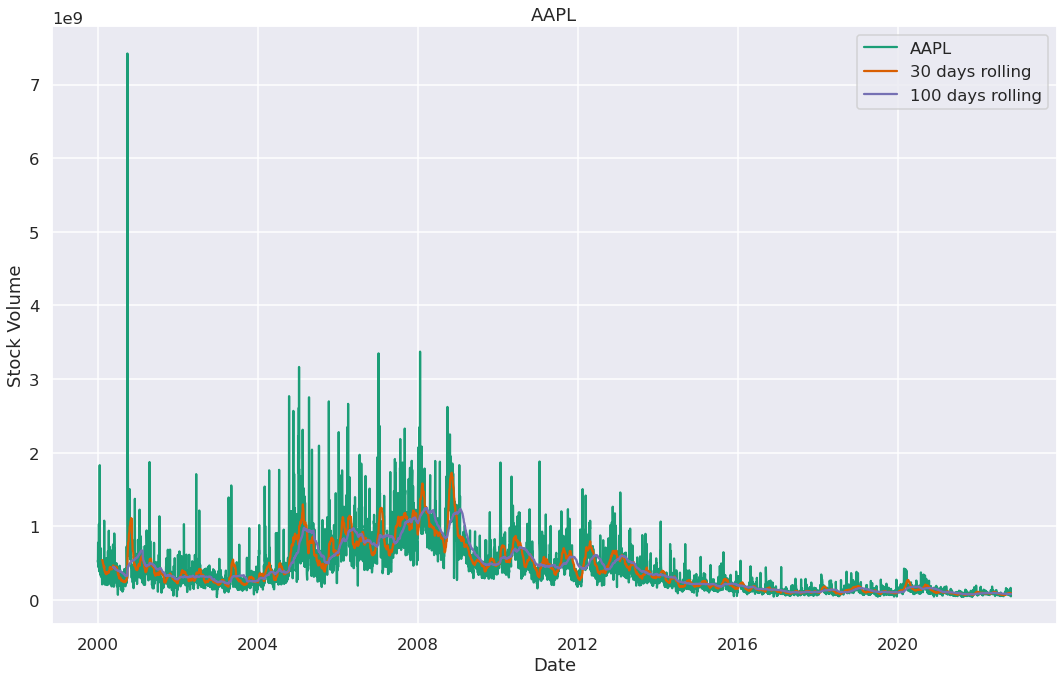

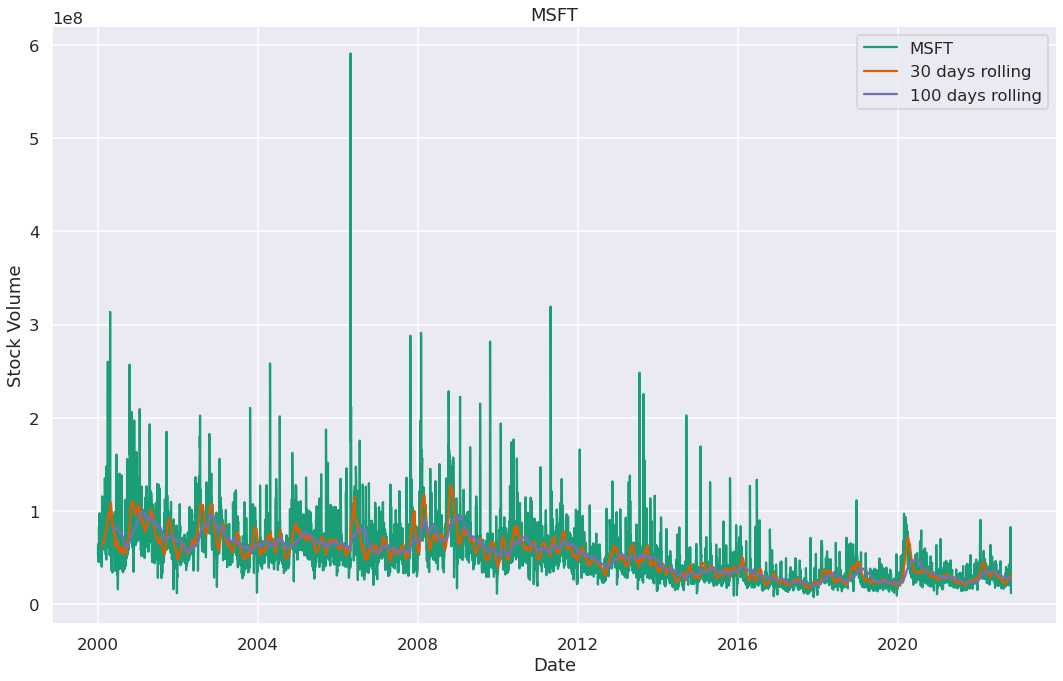

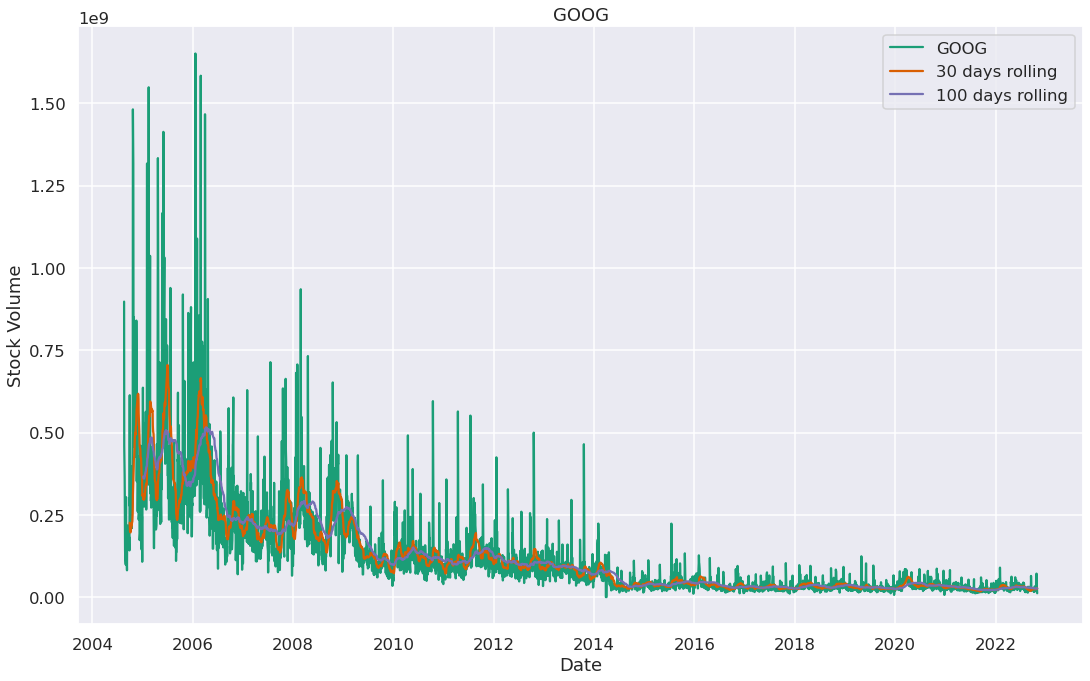

In [54]:
volume_print(tickers)

In [44]:
# Relative returns
returns = df['Close'].pct_change(1)
returns.head()

Symbols,AAPL,MSFT,GOOG
Date,,,
2000-01-03,NaN,NaN,NaN
2000-01-04,-0.084310,-0.033780,NaN
2000-01-05,0.014633,0.010544,NaN
2000-01-06,-0.086538,-0.033498,NaN
2000-01-07,0.047369,0.013068,NaN


In [45]:
# Log returns - First the logarithm of the prices is taken and the the difference of consecutive (log) observations
log_returns = np.log(df['Close']).diff()
log_returns.head()


Symbols,AAPL,MSFT,GOOG
Date,,,
2000-01-03,NaN,NaN,NaN
2000-01-04,-0.088077,-0.034364,NaN
2000-01-05,0.014527,0.010489,NaN
2000-01-06,-0.090514,-0.034072,NaN
2000-01-07,0.046281,0.012984,NaN


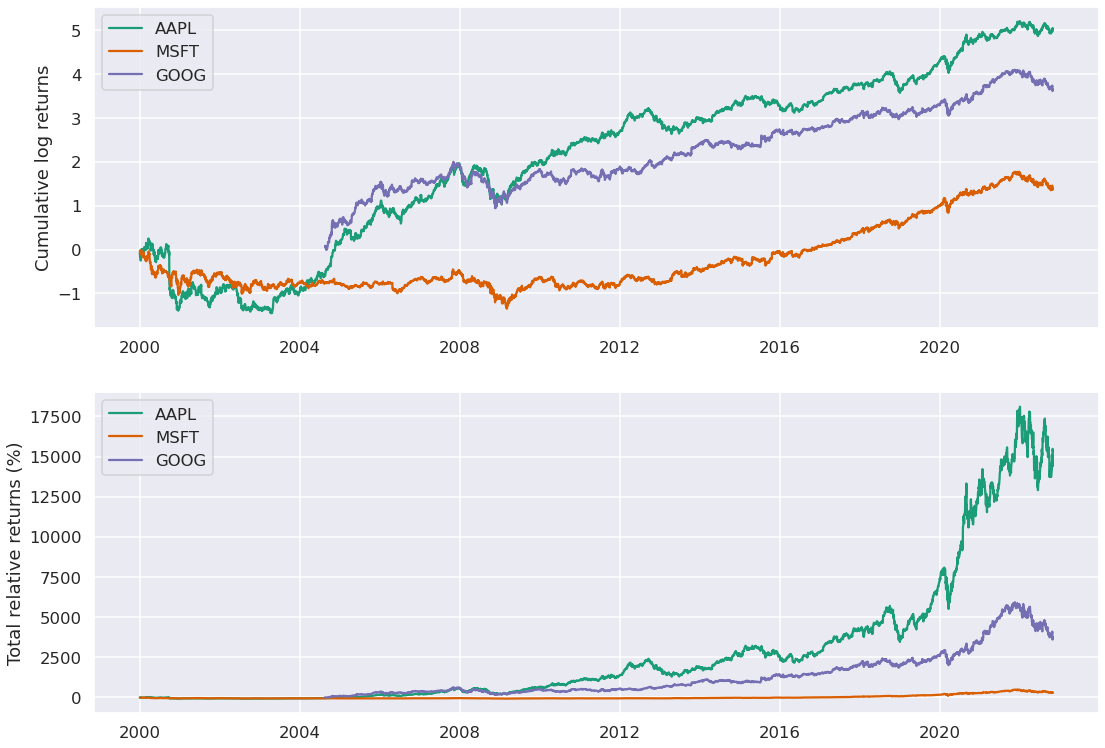

In [48]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18,13))

for c in log_returns:
    ax1.plot(log_returns.index, log_returns[c].cumsum(), label=str(c))

ax1.set_ylabel('Cumulative log returns')
ax1.legend(loc='best')

for c in log_returns:
    ax2.plot(log_returns.index, 100*(np.exp(log_returns[c].cumsum()) - 1), label=str(c))

ax2.set_ylabel('Total relative returns (%)')
ax2.legend(loc='best')

plt.show()
